In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#%matplotlib notebook

In [11]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import decomposition
from sklearn.cluster import (KMeans, AgglomerativeClustering)

SEED = 666

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
sns.set_style('white')

from dataset import get_dataset

PLOT = True

In [12]:
dataset = get_dataset(recompute=False)
y = np.array([sample['vocalization'] for sample in iter(dataset)])

123it [00:00, 1559.14it/s]


In [13]:
def compute_clustering_metrics(y, y_pred):
    
    how_clustered = np.argmax([
    metrics.accuracy_score((y + 2) % 2, y_pred),
    metrics.accuracy_score((y-1), y_pred)])

    if how_clustered == 0:
        y_gt = (y + 2) % 2
    else:
        y_gt = y-1
    
    ari = metrics.adjusted_rand_score(y_gt, y_pred)
    ami = metrics.adjusted_mutual_info_score(y_gt, y_pred)
    acc = metrics.balanced_accuracy_score(y_gt, y_pred)
    
    clustering_metrics = {
        'feat': feat,
        'ARI': ari,
        'AMI': ami,
        'BACC': acc,
    }
    
    return y_gt, clustering_metrics

In [14]:
results = []

**Naive k-means**

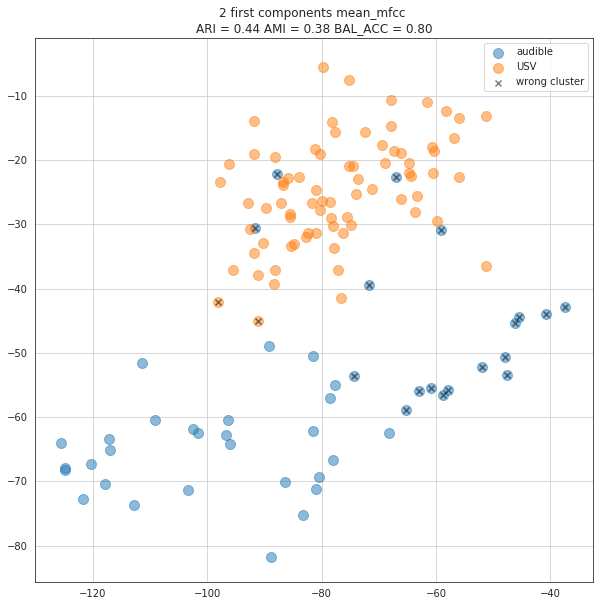

In [15]:
feat = 'mean_mfcc' 
X = np.array([sample[feat] for sample in iter(dataset)]) 

X_reduced = X[:, :2]
y_clusters = KMeans(n_clusters=2, random_state=SEED).fit_predict(X_reduced)

y_gt, mtcs = compute_clustering_metrics(y, y_clusters)

mtcs['method'] = 'NaiveKmeans'
results.append(mtcs)

if PLOT:
    X_wrong_cluster = X_reduced[y_gt != y_clusters]

    title = f"2 first components {feat} \n" \
        + f"ARI = {'{:.2f}'.format(mtcs['ARI'])} " \
        + f"AMI = {'{:.2f}'.format(mtcs['AMI'])} " \
        + f"BAL_ACC = {'{:.2f}'.format(mtcs['BACC'])}"

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(X_reduced[y == 1][:, 0], X_reduced[y == 1][:, 1],
               c='tab:blue', s=100, marker='o', label='audible', alpha=0.5)

    ax.scatter(X_reduced[y == 2][:, 0], X_reduced[y == 2][:, 1],
               c='tab:orange', s=100, marker='o', label='USV', alpha=0.5)

    ax.scatter(X_wrong_cluster[:, 0], X_wrong_cluster[:, 1],
               c='black', marker='x', label='wrong cluster', alpha=0.5)

    ax.legend()
    ax.grid(True)
    plt.title(title)
    plt.show()

## **Reduce features dimension to 2 with PCA and whitening, then apply k-means algorithme on the 2 dimensions that better explain data.**

In [8]:
for feat in ['max_mfcc', 'mean_mfcc', 'mean_stft', 'max_stft', 'mean_mel', 'max_mel']: 

    X = np.array([sample[feat] for sample in iter(dataset)]) 

    whiten = True if feat[-4:] == 'mfcc' else False
        
    pca = decomposition.PCA(whiten=whiten)
    pca.fit(X)
    # print(pca.explained_variance_) 
    pca.n_components = 2
    X_reduced = pca.fit_transform(X)

    y_clusters = KMeans(n_clusters=2, random_state=SEED).fit_predict(X_reduced)

    y_gt, mtcs = compute_clustering_metrics(y, y_clusters)

    mtcs['method'] = 'PCA+Kmeans'
    results.append(mtcs)
    
    if PLOT:
        X_wrong_cluster = X_reduced[y_gt != y_clusters]

        title = f"2 first components {feat} \n" \
            + f"ARI = {'{:.2f}'.format(mtcs['ARI'])} " \
            + f"AMI = {'{:.2f}'.format(mtcs['AMI'])} " \
            + f"BAL_ACC = {'{:.2f}'.format(mtcs['BACC'])}"

        fig, ax = plt.subplots(figsize=(10, 10))

        ax.scatter(X_reduced[y == 1][:, 0], X_reduced[y == 1][:, 1],
                   c='tab:blue', s=100, marker='o', label='audible', alpha=0.5)

        ax.scatter(X_reduced[y == 2][:, 0], X_reduced[y == 2][:, 1],
                   c='tab:orange', s=100, marker='o', label='USV', alpha=0.5)

        ax.scatter(X_wrong_cluster[:, 0], X_wrong_cluster[:, 1],
                   c='black', marker='x', label='wrong cluster', alpha=0.5)

        ax.legend()
        ax.grid(True)
        plt.title(title)
        plt.show()

## **Apply hierarchical clustering algorithme with 2 clusters.**

In [9]:
for feat in  ['max_mfcc', 'mean_mfcc', 'mean_stft', 'max_stft', 'mean_mel', 'max_mel']: 

    X = np.array([sample[feat] for sample in iter(dataset)]) 
        
    clustering = AgglomerativeClustering(
        n_clusters=2,
        affinity='euclidean',
        memory=None,
        connectivity=None,
        compute_full_tree='auto',
        linkage='ward',
        distance_threshold=None).fit(X)

    y_clusters = clustering.labels_

    y_gt, mtcs = compute_clustering_metrics(y, y_clusters)

    mtcs['method'] = 'AgglomerativeClustering'
    results.append(mtcs)
    

## **Metrics**

In [10]:
pd.DataFrame.from_records(results).sort_values(by='ARI', ascending=False).rename({
    'feat': 'Audio Feature',
    'BACC': 'Balanced Accuracy',
    'ARI': 'Adjusted Rand Index',
    'AMI': 'Adjusted Mutual Inforation',
}, axis=1)

,Audio Feature,Adjusted Rand Index,Adjusted Mutual Inforation,Balanced Accuracy,method
2,mean_mfcc,0.842175,0.753995,0.950868,PCA+Kmeans
1,max_mfcc,0.812128,0.721286,0.940230,PCA+Kmeans
8,mean_mfcc,0.812128,0.721286,0.940230,AgglomerativeClustering
11,mean_mel,0.783134,0.673795,0.941769,AgglomerativeClustering
12,max_mel,0.782973,0.672233,0.937710,AgglomerativeClustering
5,mean_mel,0.782584,0.690855,0.929591,PCA+Kmeans
6,max_mel,0.724996,0.635287,0.908315,PCA+Kmeans
7,max_mfcc,0.669399,0.585146,0.887038,AgglomerativeClustering
10,max_stft,0.617475,0.494657,0.881999,AgglomerativeClustering
4,max_stft,0.540310,0.440481,0.841965,PCA+Kmeans
